Presentation:

https://docs.google.com/presentation/d/11-wbU09rPXCYFJdFVVG6XaZmdX6Y0r0v/edit#slide=id.p1

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.feature_selection import SelectFromModel
import joblib

# 1. Data Loading and Initial Exploration

def load_data(file_path):
    return pd.read_csv(file_path)

def explore_data(df):
    print(df.info())
    print("\nSample data:")
    print(df.head())
    print("\nSummary statistics:")
    print(df.describe())
    print("\nMissing values:")
    print(df.isnull().sum())

# Load and explore data
train_file_path = '../data/raw/customer-churn-prediction-summer-2024/train.csv'
test_file_path = '../data/raw/customer-churn-prediction-summer-2024/test.csv'
train_data = load_data(train_file_path)
test_data = load_data(test_file_path)

print("Train data:")
explore_data(train_data)
print("\nTest data:")
explore_data(test_data)

Train data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5634 entries, 0 to 5633
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5634 non-null   int64  
 1   gender             5634 non-null   object 
 2   senior_citizen     5634 non-null   int64  
 3   partner            5634 non-null   object 
 4   dependents         5634 non-null   object 
 5   tenure             5634 non-null   int64  
 6   phone_service      5634 non-null   object 
 7   multiple_lines     5634 non-null   object 
 8   internet_service   5634 non-null   object 
 9   online_security    5634 non-null   object 
 10  online_backup      5634 non-null   object 
 11  device_protection  5634 non-null   object 
 12  tech_support       5634 non-null   object 
 13  streaming_tv       5634 non-null   object 
 14  streaming_movies   5634 non-null   object 
 15  contract           5634 non-null   object 
 16  paperless_bi

In [18]:
# 2. Feature Engineering

def engineer_features(df):
    # Convert categorical variables to numerical
    df['gender'] = df['gender'].map({'Male': 0, 'Female': 1})
    df['partner'] = df['partner'].map({'No': 0, 'Yes': 1})
    df['dependents'] = df['dependents'].map({'No': 0, 'Yes': 1})
    df['phone_service'] = df['phone_service'].map({'No': 0, 'Yes': 1})
    df['paperless_billing'] = df['paperless_billing'].map({'No': 0, 'Yes': 1})
    
    # Handle 'total_charges' column
    df['total_charges'] = pd.to_numeric(df['total_charges'], errors='coerce')
    df['total_charges'] = df['total_charges'].fillna(df['monthly_charges'])
    
    # Create dummy variables for multi-category columns
    categorical_columns = ['multiple_lines', 'internet_service', 'online_security', 'online_backup',
                           'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies',
                           'contract', 'payment_method']
    
    df = pd.get_dummies(df, columns=categorical_columns, drop_first=True)
    
    return df

# Engineer features
train_data_engineered = engineer_features(train_data)
test_data_engineered = engineer_features(test_data)

print("\nEngineered train data:")
print(train_data_engineered.head())
print(train_data_engineered.info())


Engineered train data:
     id  gender  senior_citizen  partner  dependents  tenure  phone_service  \
0  1815       0               0        1           1      12              1   
1  5947       1               0        0           0      42              1   
2  3882       0               0        1           0      71              1   
3  2390       0               0        1           1      71              1   
4  3677       0               0        0           0      30              1   

   paperless_billing  monthly_charges  total_charges  ...  tech_support_Yes  \
0                  0            19.70         258.35  ...             False   
1                  0            73.90        3160.55  ...              True   
2                  0            65.15        4681.75  ...              True   
3                  0            85.45        6300.85  ...              True   
4                  0            70.40        2044.75  ...              True   

   streaming_tv_No interne

Exploratory Data Analysis on Key Features:


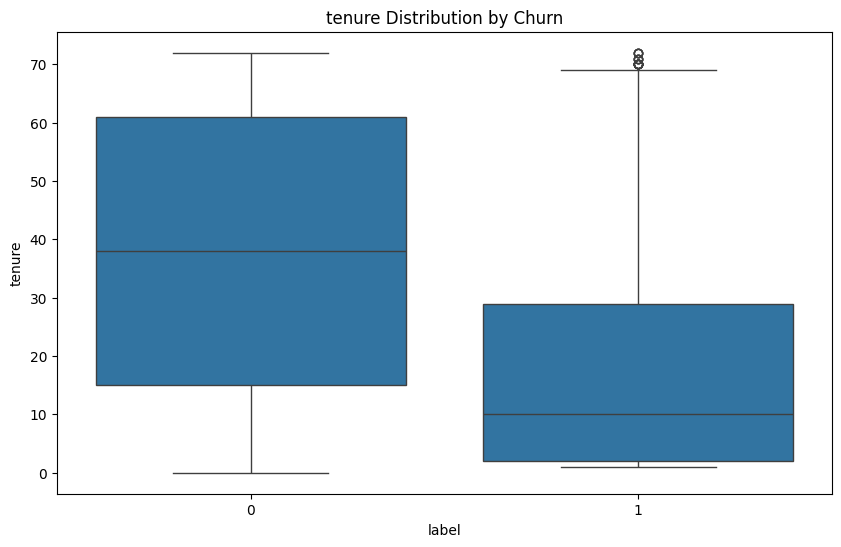

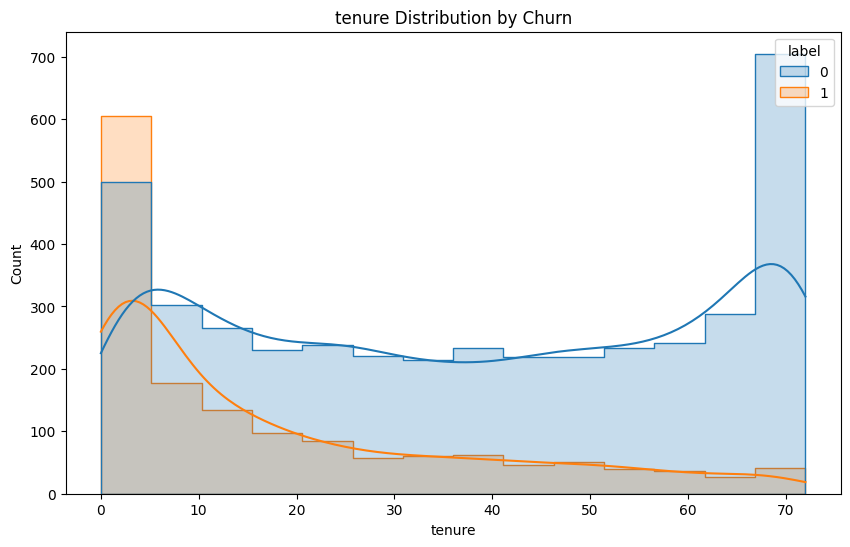

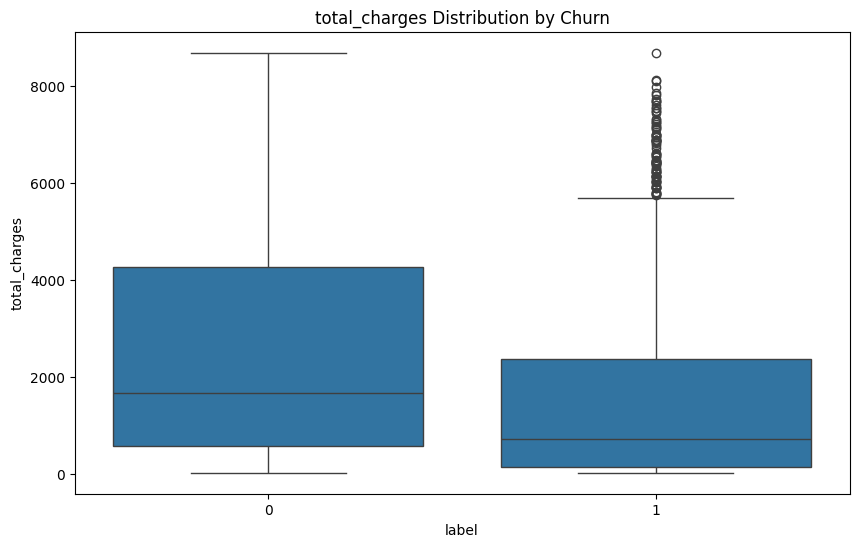

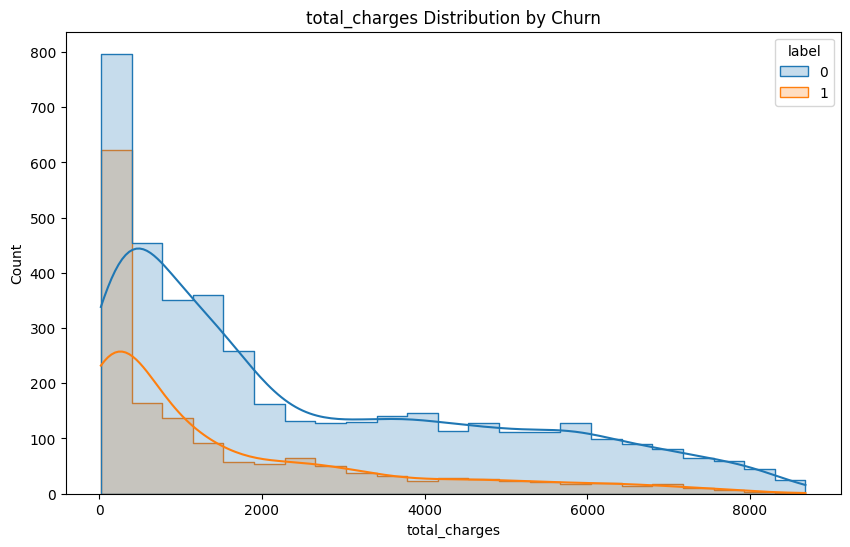

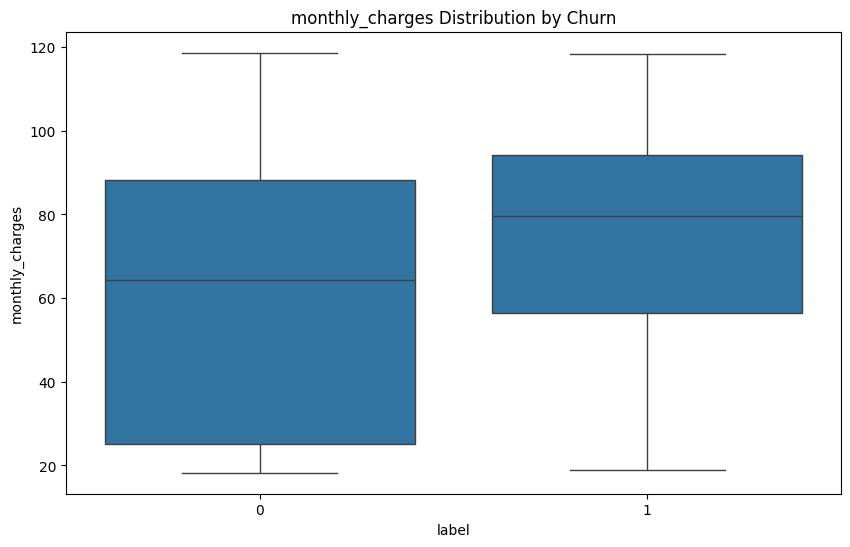

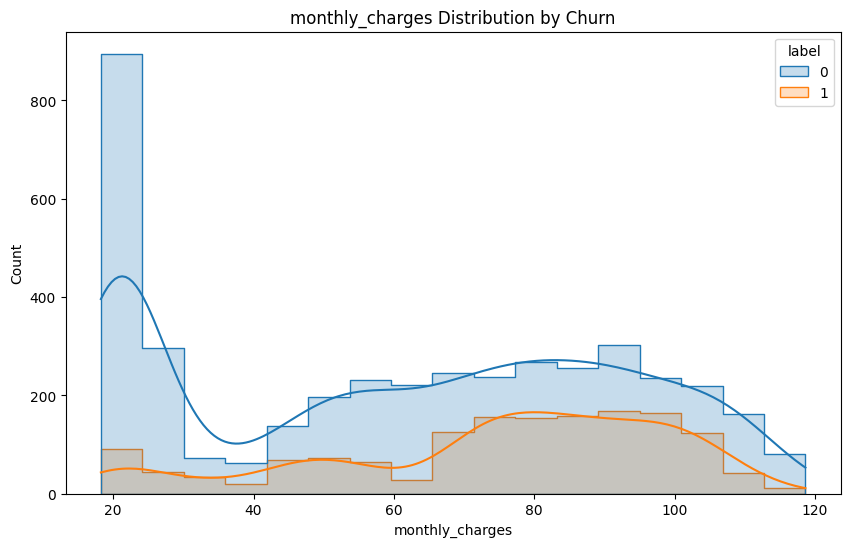

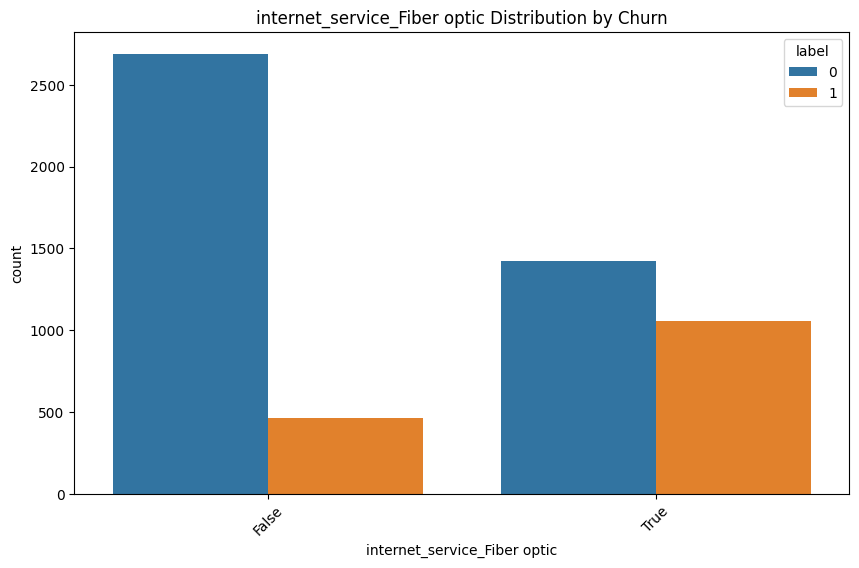

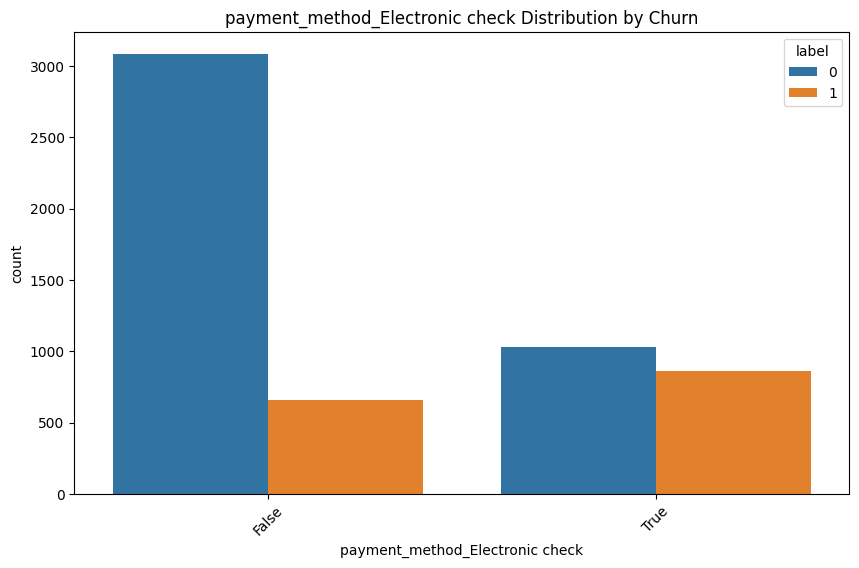

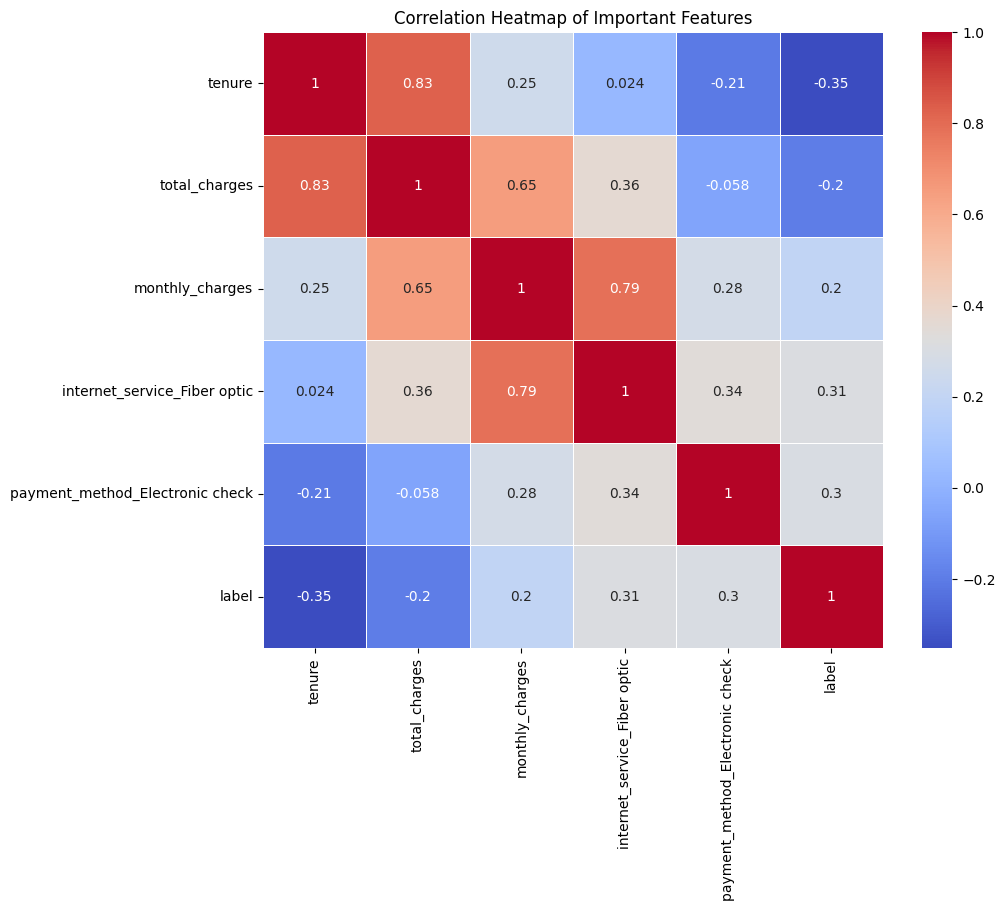

In [19]:
def plot_numerical_feature(df, feature, target='label'):
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=target, y=feature, data=df)
    plt.title(f'{feature} Distribution by Churn')
    plt.show()

    plt.figure(figsize=(10, 6))
    sns.histplot(data=df, x=feature, hue=target, kde=True, element='step')
    plt.title(f'{feature} Distribution by Churn')
    plt.show()

def plot_categorical_feature(df, feature, target='label'):
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x=feature, hue=target)
    plt.title(f'{feature} Distribution by Churn')
    plt.xticks(rotation=45)
    plt.show()

# Perform EDA on the most important features
print("Exploratory Data Analysis on Key Features:")

numerical_features = ['tenure', 'total_charges', 'monthly_charges']
categorical_features = ['internet_service_Fiber optic', 'payment_method_Electronic check']

for feature in numerical_features:
    plot_numerical_feature(train_data_engineered, feature)

for feature in categorical_features:
    plot_categorical_feature(train_data_engineered, feature)

# Correlation heatmap of important features
important_features = numerical_features + categorical_features + ['label']
correlation_matrix = train_data_engineered[important_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of Important Features')
plt.show()

In [20]:

# 4. Model Selection and Training

def prepare_data(df):
    X = df.drop(['id', 'label'], axis=1)
    y = df['label']
    return train_test_split(X, y, test_size=0.2, random_state=42)

def train_models(X_train, y_train):
    models = {
        'Random Forest': RandomForestClassifier(random_state=42),
        'Gradient Boosting': GradientBoostingClassifier(random_state=42),
        'Logistic Regression': LogisticRegression(random_state=42)
    }
    
    trained_models = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        trained_models[name] = model
    
    return trained_models

def evaluate_models(models, X_test, y_test):
    results = {}
    for name, model in models.items():
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        accuracy = accuracy_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        
        print(f"\n{name} Results:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"ROC AUC: {roc_auc:.4f}")
        print("Classification Report:")
        print(classification_report(y_test, y_pred))
        
        results[name] = {
            'accuracy': accuracy,
            'roc_auc': roc_auc,
            'model': model
        }
    
    return results

# Prepare data for modeling
X_train, X_test, y_train, y_test = prepare_data(train_data_engineered)

# Train and evaluate models
models = train_models(X_train, y_train)
results = evaluate_models(models, X_test, y_test)


Random Forest Results:
Accuracy: 0.7799
ROC AUC: 0.8124
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.90      0.86       828
           1       0.61      0.46      0.52       299

    accuracy                           0.78      1127
   macro avg       0.72      0.68      0.69      1127
weighted avg       0.77      0.78      0.77      1127


Gradient Boosting Results:
Accuracy: 0.7808
ROC AUC: 0.8224
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.89      0.86       828
           1       0.61      0.48      0.54       299

    accuracy                           0.78      1127
   macro avg       0.72      0.69      0.70      1127
weighted avg       0.77      0.78      0.77      1127


Logistic Regression Results:
Accuracy: 0.7799
ROC AUC: 0.8198
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.88      0.

c:\Users\ghadf\anaconda3\envs\ml_basics_env\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


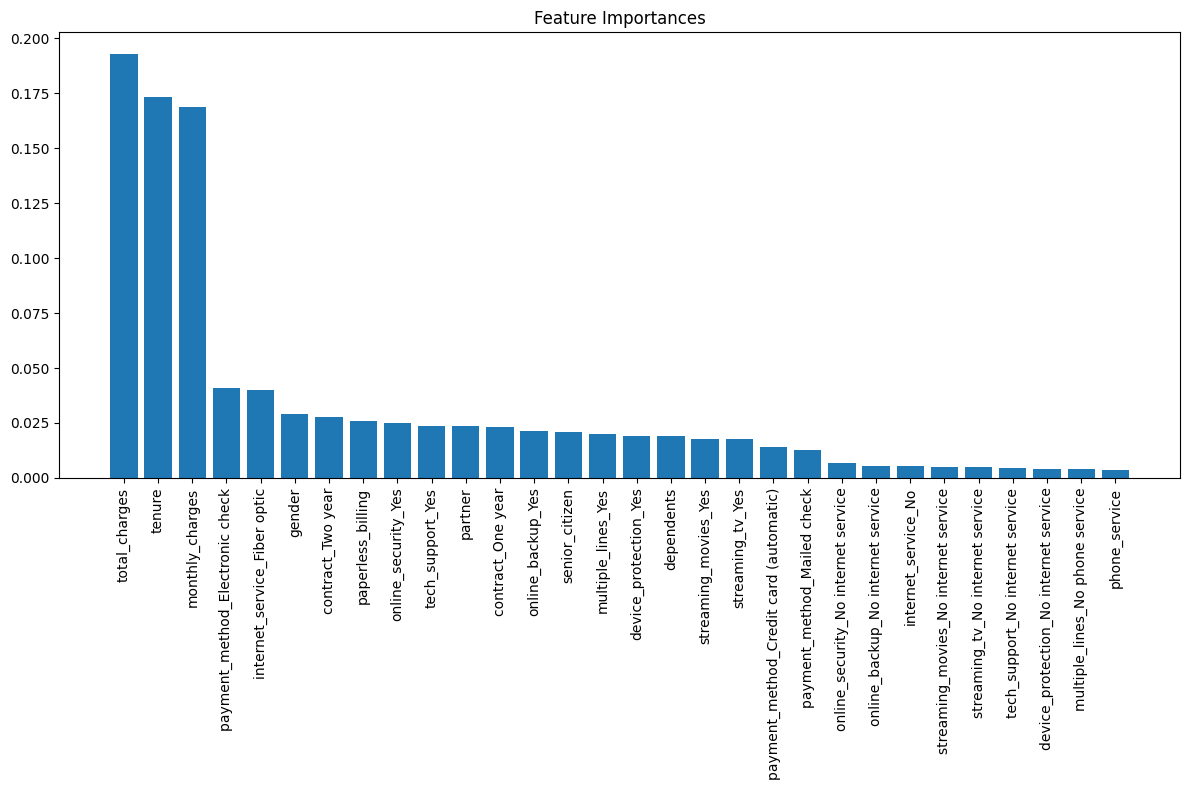

Top 10 important features:
                           feature  importance
0                    total_charges    0.193086
1                           tenure    0.173107
2                  monthly_charges    0.168872
3  payment_method_Electronic check    0.040793
4     internet_service_Fiber optic    0.039802
5                           gender    0.028997
6                contract_Two year    0.027566
7                paperless_billing    0.025787
8              online_security_Yes    0.025081
9                 tech_support_Yes    0.023543


In [21]:

# 5. Feature Importance

def plot_feature_importance(model, X):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    plt.figure(figsize=(12, 8))
    plt.title("Feature Importances")
    plt.bar(range(X.shape[1]), importances[indices])
    plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
    plt.tight_layout()
    plt.show()
    
    return pd.DataFrame({'feature': X.columns[indices], 'importance': importances[indices]})

# Plot feature importance for Random Forest
rf_importance = plot_feature_importance(models['Random Forest'], X_train)
print("Top 10 important features:")
print(rf_importance.head(10))

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best parameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}

Final Random Forest Model Results:
Accuracy: 0.7870
ROC AUC: 0.8234
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.89      0.86       828
           1       0.63      0.49      0.55       299

    accuracy                           0.79      1127
   macro avg       0.73      0.69      0.71      1127
weighted avg       0.78      0.79      0.78      1127



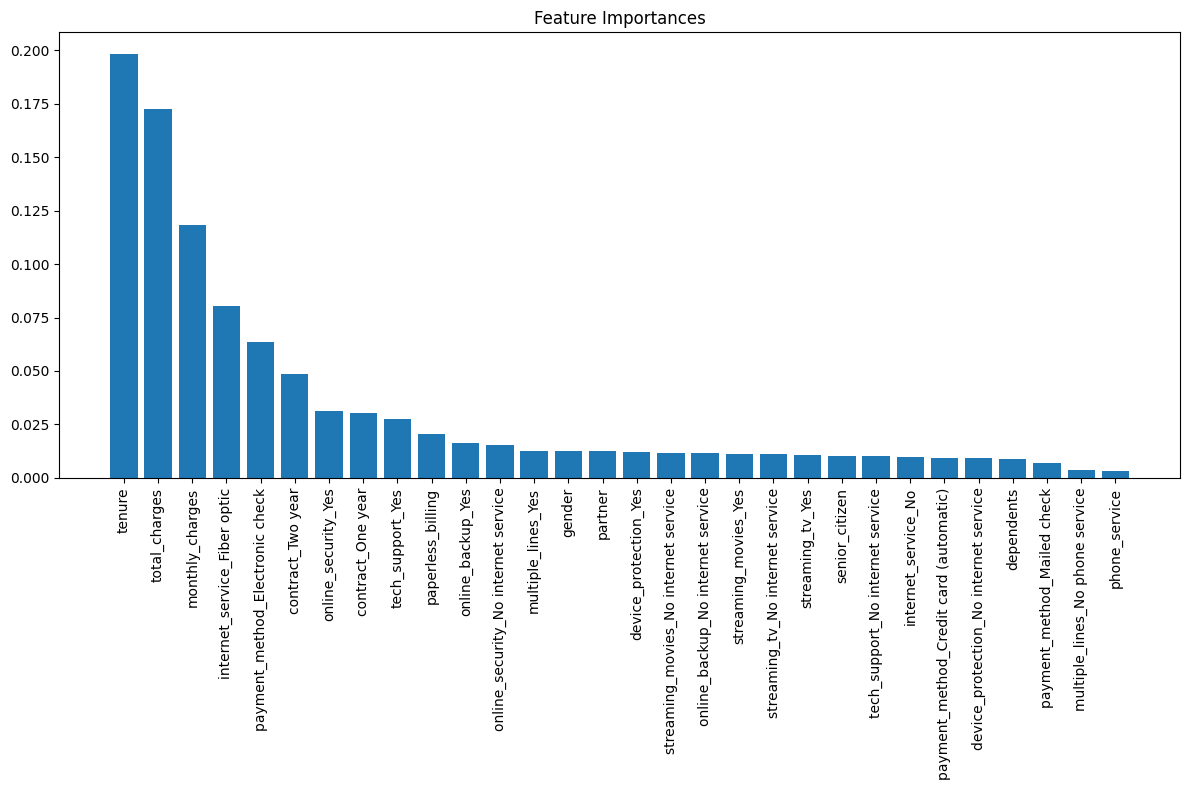

Top 10 important features (tuned Random Forest):
                           feature  importance
0                           tenure    0.198430
1                    total_charges    0.172405
2                  monthly_charges    0.118275
3     internet_service_Fiber optic    0.080438
4  payment_method_Electronic check    0.063426
5                contract_Two year    0.048370
6              online_security_Yes    0.031054
7                contract_One year    0.030202
8                 tech_support_Yes    0.027413
9                paperless_billing    0.020567
these hyperparameters were selected because they provide a good balance between model complexity and generalization ability. The resulting model shows strong overall performance in predicting customer churn, with particularly good performance in identifying customers likely to stay. The slightly lower performance on predicting churned customers suggests that this is a challenging problem, possibly due to class imbalance or complex

In [22]:

# 6. Hyperparameter Tuning

def tune_random_forest(X_train, y_train):
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    
    rf = RandomForestClassifier(random_state=42)
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
    grid_search.fit(X_train, y_train)
    
    print("Best parameters:", grid_search.best_params_)
    return grid_search.best_estimator_

# Tune Random Forest
best_rf = tune_random_forest(X_train, y_train)

# Final evaluation
print("\nFinal Random Forest Model Results:")
y_pred = best_rf.predict(X_test)
y_pred_proba = best_rf.predict_proba(X_test)[:, 1]
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"Accuracy: {accuracy:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Plot feature importance for tuned Random Forest
tuned_rf_importance = plot_feature_importance(best_rf, X_train)
print("Top 10 important features (tuned Random Forest):")
print(tuned_rf_importance.head(10))

print("these hyperparameters were selected because they provide a good balance between model complexity and generalization ability. The resulting model shows strong overall performance in predicting customer churn, with particularly good performance in identifying customers likely to stay. The slightly lower performance on predicting churned customers suggests that this is a challenging problem, possibly due to class imbalance or complex patterns in the data that lead to churn. This model provides a solid foundation for predicting churn, but there might be room for further improvement, especially in identifying customers at risk of churning.")

In [23]:

# 7. Save Model and Features

def save_model_and_features(model, features, output_dir):
    joblib.dump(model, f'{output_dir}/best_model.joblib')
    pd.DataFrame(features).to_csv(f'{output_dir}/feature_importance.csv', index=False)
    print(f"Model and features saved to {output_dir}")

output_dir = '../data/raw/customer-churn-prediction-summer-2024'
save_model_and_features(best_rf, tuned_rf_importance, output_dir)

Model and features saved to ../data/raw/customer-churn-prediction-summer-2024


In [24]:

# 8. Generate Submission

def generate_submission(model, test_data, output_file):
    X_test = test_data.drop(['id'], axis=1)
    predictions = model.predict(X_test)
    submission = pd.DataFrame({'id': test_data['id'], 'label': predictions})
    submission.to_csv(output_file, index=False)
    print(f"Submission file saved to {output_file}")

submission_file = '../data/raw/customer-churn-prediction-summer-2024/random_forest_submission.csv'
generate_submission(best_rf, test_data_engineered, submission_file)

Submission file saved to ../data/raw/customer-churn-prediction-summer-2024/random_forest_submission.csv


In [25]:

# 7. Analysis and Insights

print("\nAnalysis and Insights:")
print("1. Model Performance:")
print(f"   - The tuned Random Forest model achieved an accuracy of {accuracy:.4f} and ROC AUC of {roc_auc:.4f}.")
print("   - This indicates good overall performance, with the model correctly predicting churn in most cases.")

print("\n2. Feature Importance Analysis:")
print("   Top 5 most important features:")
for i, row in tuned_rf_importance.head(5).iterrows():
    print(f"   - {row['feature']}: {row['importance']:.4f}")

print("\n3. Key Insights from EDA:")
print("   - Tenure: Customers with longer tenure are less likely to churn. There's a clear difference in the distribution of tenure between churned and non-churned customers.")
print("   - Total Charges: Higher total charges are associated with lower churn rates, possibly indicating that long-term, high-value customers are more loyal.")
print("   - Monthly Charges: There's a slight trend showing that higher monthly charges are associated with higher churn rates, suggesting a balance needs to be struck between revenue and retention.")
print("   - Internet Service (Fiber Optic): Customers with fiber optic service seem to have a higher churn rate. This could be due to pricing or service quality issues.")
print("   - Payment Method (Electronic Check): Customers using electronic checks as their payment method appear to have a higher churn rate. This could be related to demographics or ease of cancellation.")

print("\n4. Recommendations:")
print("   Based on these insights, we recommend the following actions to reduce churn:")
print("   - Implement targeted loyalty programs for customers in their early tenure to encourage longer-term relationships.")
print("   - Review the pricing strategy for monthly charges, possibly offering discounts or added value for longer-term commitments.")
print("   - Investigate and improve the fiber optic internet service to address potential issues causing higher churn rates.")
print("   - Develop retention strategies for customers using electronic checks as their payment method, possibly incentivizing them to switch to other payment methods.")

print("\n5. Next Steps:")
print("   - Conduct A/B tests on retention strategies based on these insights.")
print("   - Regularly retrain the model with new data to capture evolving patterns.")
print("   - Explore more advanced models or ensemble techniques to potentially improve performance.")
print("   - Investigate the possibility of collecting additional features that might further improve prediction accuracy.")


Analysis and Insights:
1. Model Performance:
   - The tuned Random Forest model achieved an accuracy of 0.7870 and ROC AUC of 0.8234.
   - This indicates good overall performance, with the model correctly predicting churn in most cases.

2. Feature Importance Analysis:
   Top 5 most important features:
   - tenure: 0.1984
   - total_charges: 0.1724
   - monthly_charges: 0.1183
   - internet_service_Fiber optic: 0.0804
   - payment_method_Electronic check: 0.0634

3. Key Insights from EDA:
   - Tenure: Customers with longer tenure are less likely to churn. There's a clear difference in the distribution of tenure between churned and non-churned customers.
   - Total Charges: Higher total charges are associated with lower churn rates, possibly indicating that long-term, high-value customers are more loyal.
   - Monthly Charges: There's a slight trend showing that higher monthly charges are associated with higher churn rates, suggesting a balance needs to be struck between revenue and ret